In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [7]:
link = '/Users/selinwork/Documents/Ironhack/Ironhack_Week_6/project-4-cv/bone-fracture/Bone_Fracture_Binary_Classification'

<h2 style="color: #FF6347;">Data Extraction</h2>

In [8]:
data_path = link
print(data_path)

/Users/selinwork/Documents/Ironhack/Ironhack_Week_6/project-4-cv/bone-fracture/Bone_Fracture_Binary_Classification


<h3 style="color: #FF6347;">Train-Test-Val Datasets</h3>

In [9]:
train_dir = os.path.join(data_path, 'train')
validation_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

<h2 style="color: #FF6347;">Hyperparatmeters</h2>

In [10]:
batch_size = 32
img_size = (160,160)
img_shape = img_size + (3,)
autotune = tf.data.AUTOTUNE

<h3 style="color: #FF6347;">Processing Test-Val Test:</h3>

In [11]:
def load_dataset(directory):
    try:
        return tf.keras.utils.image_dataset_from_directory(directory, shuffle=True, batch_size=batch_size, image_size=img_size)
    except Exception as e:
        print(f"Error loading dataset from {directory}: {e}")
        return None
    
def remove_corrupted_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = tf.io.read_file(file_path)
                img = tf.image.decode_jpeg(img)
            except:
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)

In [12]:
remove_corrupted_images(train_dir)
remove_corrupted_images(validation_dir)
remove_corrupted_images(test_dir)

2025-01-16 17:25:28.378155: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: bKGD: invalid
2025-01-16 17:25:28.563062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: bKGD: invalid
2025-01-16 17:25:28.715374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-01-16 17:25:30.059622: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-01-16 17:25:30.720106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-01-16 17:25:31.642575: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: bKGD: invalid
2025-01-16 17:25:31.849378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-01-16 17:25:35.404094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


In [13]:
train_dataset = load_dataset(train_dir)
validation_dataset = load_dataset(validation_dir)
test_dataset = load_dataset(test_dir)

Found 9240 files belonging to 2 classes.
Found 823 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [14]:
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

<h2 style="color: #FF6347;">DenseNet-121 Model:</h2>

In [15]:
# Load pre-trained DenseNet121 without the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduces dimensions and prevents overfitting
    Dense(256, activation='relu'),  # Dense layer
    Dropout(0.5),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    'bone-fracture/Bone_Fracture_Binary_Classification/train',
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/Users/selinwork/Documents/Ironhack/Ironhack_Week_6/project-4-cv/bone-fracture/Bone_Fracture_Binary_Classification/val',
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

Found 9240 images belonging to 2 classes.
Found 823 images belonging to 2 classes.


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 126s 435ms/step - accuracy: 0.9479 - loss: 0.1264 - val_accuracy: 0.9635 - val_loss: 0.1255
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 138s 478ms/step - accuracy: 0.9512 - loss: 0.1276 - val_accuracy: 0.9587 - val_loss: 0.1326
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 145s 501ms/step - accuracy: 0.9519 - loss: 0.1298 - val_accuracy: 0.9575 - val_loss: 0.1192
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 145s 501ms/step - accuracy: 0.9546 - loss: 0.1174 - val_accuracy: 0.9611 - val_loss: 0.1173
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 144s 500ms/step - accuracy: 0.9601 - loss: 0.1069 - val_accuracy: 0.9563 - val_loss: 0.1269
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 150s 517ms/step - accuracy: 0.9598 - loss: 0.1074 - val_accuracy: 0.9575 - val_loss: 0.1166
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 149s 516ms/step - accuracy: 0.9567 - loss: 0.1056 - val_accuracy: 0.9502 - val_loss: 0.1386
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 152s 526ms/step - accuracy: 0.9656 -

In [22]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.9722 - loss: 0.1015
Validation Accuracy: 97.57%


<h2 style="color: #FF6347;">Evaluation and Visualisation of the Results</h2>

In [24]:
model.save('my_model_densenet.keras')

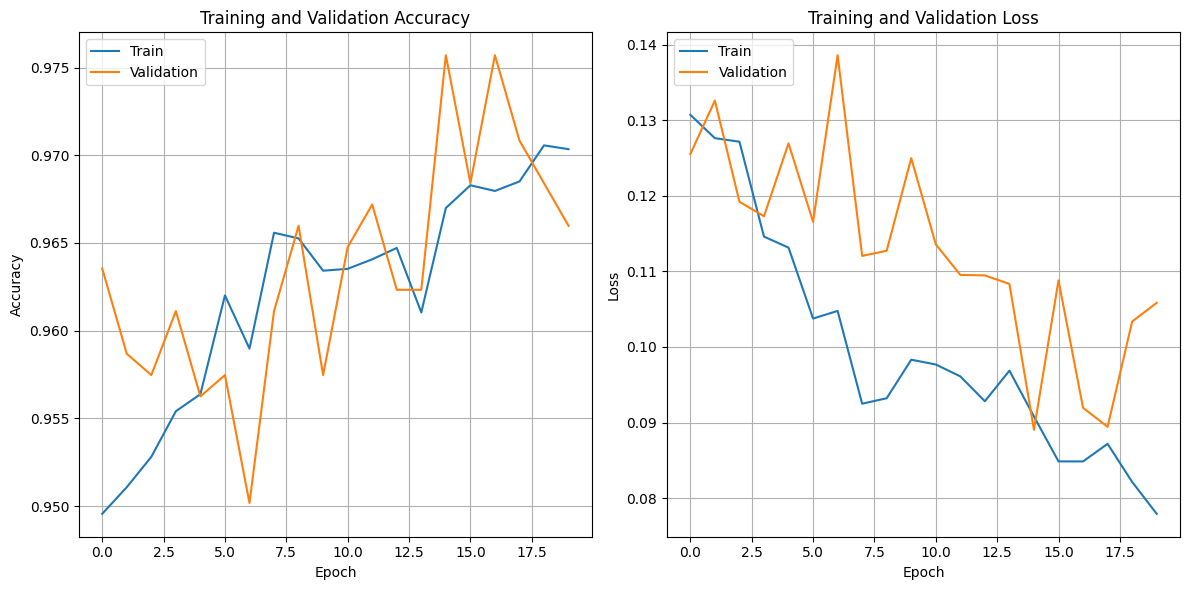

In [34]:
# Plot accuracy and loss on the same grid
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
# Reality and predictions from the test dataset
new_data = np.concatenate([labels.numpy() for _, labels in test_dataset]) 
predictions = np.concatenate([tf.where(model(X).numpy().flatten() < 0.5, 0, 1).numpy() for X, _ in test_dataset]) 

2025-01-16 22:19:52.946108: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-16 22:20:03.710458: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
from sklearn.metrics import classification_report

In [30]:
# Define class names
class_names = ['Class 0', 'Class 1']

# Print classification report
print("Classification Report:")
print(classification_report(new_data, predictions, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.49      0.53      0.51       238
     Class 1       0.54      0.51      0.52       262

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.52      0.52      0.52       500



<h2 style="color: #FF6347;">Testing the Model</h2>

In [31]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'bone-fracture/Bone_Fracture_Binary_Classification/test/fractured/1-rotated3-rotated1-rotated1.jpg'
img_size = (160, 160)  # Match your model's input size

# Load and preprocess the image
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

In [32]:
prediction = model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
[[0.00129479]]


In [33]:
# Load and preprocess the image
img_path = '/Users/selinwork/Documents/Ironhack/Ironhack_Week_6/project-4-cv/test_image.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image

prediction = model.predict(img_array)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[0.6794477]]
